In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
import scipy.signal
from uvtools import dspec
from matplotlib.colors import LogNorm

In [10]:
uvd_eor = UVData()
uvd_eor.read('./simulated_array_ddish_4_nant_10_eor.uvh5')

uvd_gsm = UVData()
uvd_gsm.read('./simulated_array_ddish_4_nant_10_gsm.uvh5')

antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.


In [28]:
def fft1d(x):
    w = dspec.gen_window('bh7', x.shape[1])
    return np.fft.fftshift(np.fft.fft(np.fft.fftshift(x * w[None,:], axes=1), axis=1), axes=1)

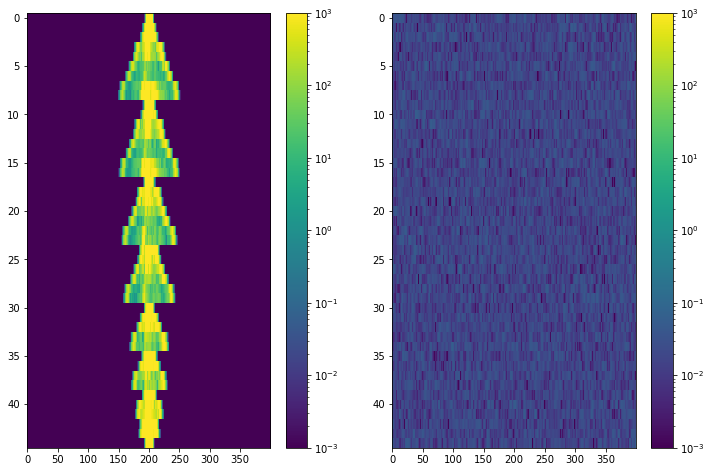

In [29]:
fig, axarr = plt.subplots(1,2)
plt.sca(axarr[0])
plt.imshow(np.abs(fft1d(uvd_gsm.data_array.squeeze())), aspect='auto', interpolation='nearest', norm=LogNorm(1e-3, 1e3))
plt.colorbar()
plt.sca(axarr[1])
plt.imshow(np.abs(fft1d(uvd_eor.data_array.squeeze())), aspect='auto', interpolation='nearest', norm=LogNorm(1e-3, 1e3))
plt.colorbar()
plt.gcf().set_size_inches(12, 8)

Try Kreiging the Foregrounds onto a uniform grid.

In [38]:
bllens = np.linalg.norm(uvd_gsm.uvw_array, axis=1)
umax = bllens.max() * uvd_gsm.freq_array[0][200] / 3e8
umin = bllens.min() * uvd_gsm.freq_array[0][200] / 3e8

In [39]:
(bllens.max() - bllens.min()) / 4.

53.99999999999419

In [85]:
uvals = np.linspace(umin, umax, 24, endpoint=True)

Interpolate with 
\begin{equation}
\text{Sinc}[2 \pi \tau_w (\nu_i - \nu_j)]
\end{equation}

for each baseline, determine frequencies of missing $u$ values.

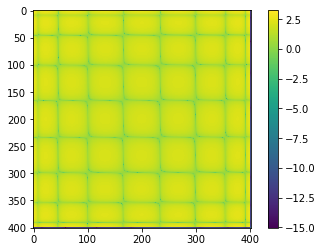

In [86]:
plt.imshow(np.log10(np.abs(np.linalg.pinv(cov + mask))))
plt.colorbar()

In [87]:
interpolated_data = []
interpolated_freqs = []
interpolated_d = [[] for u in uvals]
interpolated_f = [[] for u in uvals]
for blnum in range(uvd_gsm.Nbls):
    uvbl = bllens[blnum] * uvd_gsm.freq_array[0] / 3e8
    uvals_selection = (uvals >= uvbl.min()) & (uvals <= uvbl.max())
    ninterp = np.count_nonzero(uvals_selection)
    if np.count_nonzero(uvals_selection) > 0:
        uvbl = np.hstack([bllens[blnum] * uvd_gsm.freq_array[0] / 3e8, uvals[uvals_selection]])
        freqsbl = uvbl / bllens[blnum]*3e8
        xg, yg = np.meshgrid(freqsbl, freqsbl)
        cov = np.sinc(2 * bllens[blnum] / 3e8 * (xg - yg))
        mask = np.zeros(cov.shape[0])
        # set mask on interpolated channels
        mask[uvd_gsm.Nfreqs:] = 1e9 
        mask = np.diag(mask)
        tinterp = cov @ np.linalg.pinv(cov + mask) @ np.hstack([uvd_gsm.data_array[blnum, 0, :, 0].squeeze(), np.zeros(ninterp)])
        interpolated_data.append(tinterp)
        interpolated_freqs.append(freqsbl)
        # find uindex
        uinds = np.where(uvals_selection)[0]
        for unum, uind in enumerate(uinds):
            interpolated_d[uind].append(tinterp[uvd_gsm.Nfreqs:][unum])
            interpolated_f[uind].append(freqsbl[uvd_gsm.Nfreqs:][unum])
            

In [88]:
nu = [len(uif) for uif in interpolated_f]

In [92]:
uvd_gsm.freq_array.max() - uvd_gsm.freq_array.min()

59850000.0

Text(0, 0.5, 'N(u)')

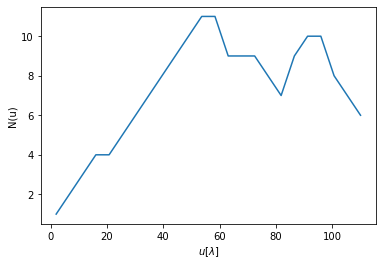

In [93]:
plt.plot(uvals, nu)
plt.xlabel('$u [\lambda]$')
plt.ylabel('N(u)')

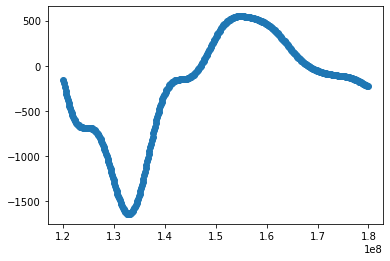

In [72]:
plt.plot(interpolated_freqs[1], interpolated_data[1], ls='none', marker='o')
#plt.plot(interpolated_freqs[1], uvd_gsm.data_array[1, 0, :, 0])

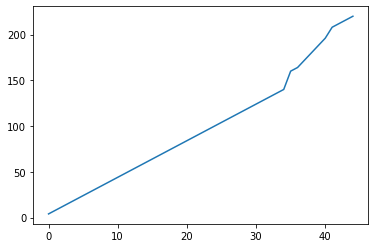

In [40]:
plt.plot(np.sort(bllens))